In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Dropout,Flatten,Conv2D,Input,MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### Data generator

In [2]:
root_path = r"E:\deep_learning\skin_cancer\dataset\dataset"
img_width,img_height = 128,128
model_input = (img_width,img_height,3)
img_size = (img_width,img_height)
batch_size = 32

In [3]:


_datagen = ImageDataGenerator(
        rescale=1/255,
		width_shift_range=0.1,
		height_shift_range=0.1,
		horizontal_flip=True)

train_gen = _datagen.flow_from_directory(
    root_path+"/train",
    target_size = img_size,
    batch_size=batch_size,
    class_mode = "categorical"
)


test_gen = _datagen.flow_from_directory(
    root_path+"/test",
    target_size = img_size,
    batch_size=batch_size,
    class_mode = "categorical"
)

Found 2967 images belonging to 3 classes.
Found 330 images belonging to 3 classes.


#### Create model

In [4]:
from pyexpat import model
from statistics import mode


def create_model(input_size,kernel_size,num_filter,num_conv_layer,num_output):
    model = Sequential(Conv2D(num_filter,kernel_size = kernel_size,padding='same',activation = 'relu',input_shape =input_size ))
    for i in range(num_conv_layer):
        model.add(Conv2D(num_filter,kernel_size = kernel_size,padding='same',activation = 'relu'))
        model.add(Conv2D(num_filter,kernel_size = kernel_size,padding='same',activation = 'relu'))

        model.add(MaxPooling2D(2, 2))
        num_filter= num_filter+num_filter
    model.add(Flatten())
    model.add(Dense(units = num_output,activation = "softmax"))
    return model

#### Parameter and train

In [5]:
conv_layers = 2
num_filter = 32
kernel_size = (3,3)
num_train = len(train_gen.filenames)
num_test = len(test_gen.filenames)
steps_per_epoch=int(num_train / batch_size)

epochs =3


In [6]:
model = create_model(input_size= model_input,
                kernel_size = kernel_size,
                num_filter=num_filter,
                num_conv_layer = conv_layers,
                num_output=3)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        36928     
                                                        

In [7]:


model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

c:\Users\tharh\anaconda3\envs\tharhtet\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [8]:
history = model.fit_generator(train_gen, steps_per_epoch=steps_per_epoch, epochs=epochs,
                            validation_data=test_gen,
                            validation_steps=int(num_test / batch_size))

C:\Users\tharh\AppData\Local\Temp\ipykernel_2704\1490670082.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, steps_per_epoch=steps_per_epoch, epochs=epochs,


Epoch 1/3
92/92 [==============================] - 17s 150ms/step - loss: 0.8379 - accuracy: 0.5949 - val_loss: 0.7177 - val_accuracy: 0.6750
Epoch 2/3
92/92 [==============================] - 13s 139ms/step - loss: 0.6511 - accuracy: 0.6978 - val_loss: 0.7265 - val_accuracy: 0.6281
Epoch 3/3
92/92 [==============================] - 13s 140ms/step - loss: 0.6328 - accuracy: 0.7019 - val_loss: 0.6379 - val_accuracy: 0.7031


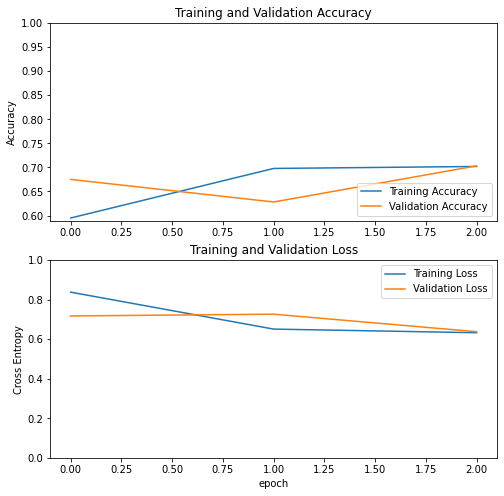

In [9]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()